In [51]:
from tensorflow.keras.datasets import fashion_mnist
import pandas as pd
import numpy as np
import os
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature

In [3]:
import cv2

### Reading the dataset

In [52]:
Xtr=np.loadtxt("TrainData/TrainData.csv")
Ytr=np.loadtxt("TrainLabels.csv")

In [53]:
images = []
for img in Xtr:
    images.append(img.reshape(28,28))

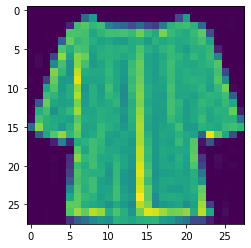

In [12]:
plt.imshow(images[0])

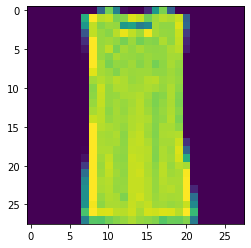

In [13]:
plt.imshow(images[2])

In [65]:
ed = feature.canny(images[0], sigma=5)

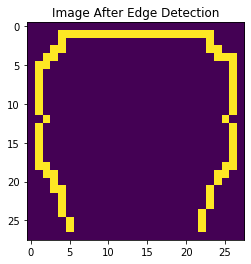

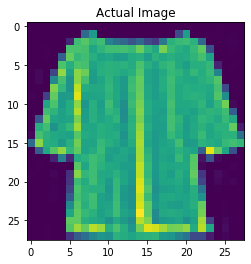

In [66]:
plt.imshow(ed)
plt.title("Image After Edge Detection")
plt.show()
plt.imshow(images[0])
plt.title("Actual Image")
plt.show()

### extracting the edge features from the entire dataset

In [67]:
im_edge = []
for im in images:
    im_edge.append(feature.canny(im, sigma=5))

#### Visualization of a few images of the items after feature extraction

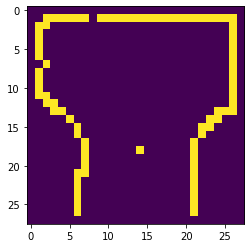

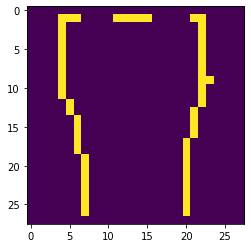

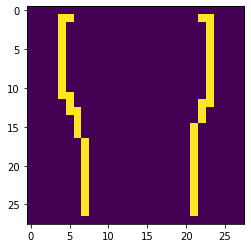

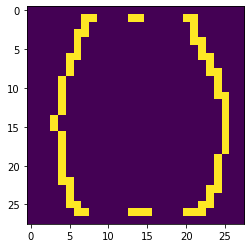

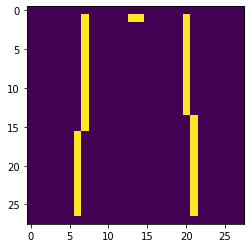

In [68]:
for i in range(-1,-6,-1):
    plt.imshow(im_edge[i])
    plt.show()

In [70]:
Ytr

array([-1.,  1.,  1., ...,  1., -1., -1.])

###  Flatten the entire dataset

In [74]:
images = []
for im in im_edge:
    images.append(im.flatten())

### function to extract the features

In [96]:
def extractfeature(Xtr):
    images = []
    for img in Xtr:
        images.append(img.reshape(28,28))
    im_edge = []
    for im in images:
        im_edge.append(feature.canny(im, sigma=5))
    images = []
    for im in im_edge:
        images.append(im.flatten())
    return np.array(images)

In [78]:
from sklearn.model_selection import train_test_split
X_train,X_cv,y_train,y_cv = train_test_split(np.array(images),Ytr,test_size=0.1,random_state=13)

In [79]:
X_train.shape

(10800, 784)

### using Simple Logistic Regression to classify the imeags

In [86]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score

## 5-fold cross validation to find optimal hyperparameter

In [89]:
vacc = []
tacc = []
for c in [.01,.1,1,10,100]:   
    model = LR(C=c)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(c,"Validation ACCURACY---------------->",sum(scores)/5)

0.01 Validation ACCURACY----------------> 0.7516666666666667
0.1 Validation ACCURACY----------------> 0.7532407407407408
1 Validation ACCURACY----------------> 0.7462962962962963
10 Validation ACCURACY----------------> 0.7410185185185185
100 Validation ACCURACY----------------> 0.7402777777777778


- Optimal C using k-fold cross validation : 0.1
### Hyperparameter tunning of the model using the given features only

In [91]:
model = LR(C = .1)
model.fit(X_train,y_train)
y_pre = model.predict(X_cv)
y_pre1 = model.predict(X_train)
x1 = accuracy_score(y_cv,y_pre)
x2 = accuracy_score(y_train,y_pre1)
vacc.append(x1)
tacc.append(x2) 
print("Test Accuracy---------------->",x1)
print("Training ACCURACY---------------->",x2)

Test Accuracy----------------> 0.7616666666666667
Training ACCURACY----------------> 0.7761111111111111


### Applying XGboost

In [93]:
import xgboost as xgb
import scikitplot.metrics as skplt

In [95]:
## hyperparameter tunning
depth=[1, 30, 100,200]
est=[1, 50, 150,300]
cv = []              # to store the cross validation accuracy on the cv dataset (final_cv)
cv_auc=0
opt_sample_est = 0
opt_depth = 0
print("Depth-----------------estimators-------------Accuracy")
for d in depth:
    for s in est:
        model = xgb.XGBClassifier(n_estimators = s,max_depth = d,n_jobs = -1)
        scores = cross_val_score(model, X_train, y_train, cv=5)
        score = sum(scores)/5
        if(score > cv_auc):
            opt_depth = d
            opt_sample_est = s
            cv_auc = score
        cv.append(cv_auc) 
        print(d,"--------------------",s,"--------------------",score)
print("Max Accuracy Score :",cv_auc)
print("Optimal_depth :",opt_depth)
print("Optimal No of estimators :",opt_sample_est)

Depth-----------------estimators-------------Accuracy
1 -------------------- 1 -------------------- 0.6425925925925926
1 -------------------- 50 -------------------- 0.7283333333333333
1 -------------------- 150 -------------------- 0.7425925925925926
1 -------------------- 300 -------------------- 0.7476851851851851
30 -------------------- 1 -------------------- 0.692962962962963
30 -------------------- 50 -------------------- 0.7483333333333333
30 -------------------- 150 -------------------- 0.7453703703703705
30 -------------------- 300 -------------------- 0.7437037037037036
100 -------------------- 1 -------------------- 0.6925925925925925
100 -------------------- 50 -------------------- 0.7460185185185184
100 -------------------- 150 -------------------- 0.7462037037037037
100 -------------------- 300 -------------------- 0.745
200 -------------------- 1 -------------------- 0.6925925925925925
200 -------------------- 50 -------------------- 0.7460185185185184
200 --------------

### Creating heatmap to find out the optimal set of hyperparameters

In [177]:
import numpy as np
import seaborn as sns
def createHeatMap(alpha,gamma1,roc_auc_cv1):
    l = []
    for i in alpha:
        for g in gamma1:
            l.append([i,g])
    l = np.asarray(l)
    df = pd.DataFrame(l, columns=['depth','estimators'])
    df['cv_score'] = roc_auc_cv1
    df.head()
    sns.set()
    data = df.pivot("depth", "estimators", "cv_score")
    ax = sns.heatmap(data, annot=True, fmt=".3f")

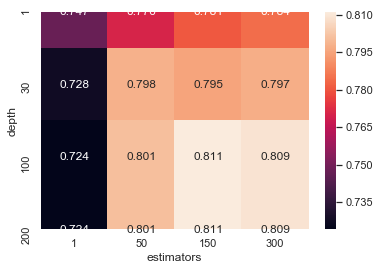

In [178]:
createHeatMap(depth,est,cv)

In [179]:
clf = xgb.XGBClassifier(n_estimators = 150,max_depth = 100,n_jobs = -1)
clf.fit(X_train,y_train)
prediction1 = clf.predict(X_test)

AUC score on test data: 0.8016666666666666
Test confusion matrix


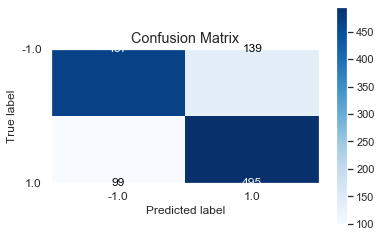

In [181]:
print("AUC score on test data:",accuracy_score(y_test,prediction1))
print("Test confusion matrix")
skplt.plot_confusion_matrix(y_test,clf.predict(X_test))